In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import sklearn.manifold as manifold
from jupyterthemes import jtplot ; jtplot.style()
from glob import glob
from os import chdir 
path = '/Users/Alby/Desktop/NEUROMATCH/load'
chdir(path)

        
        
    else :
        print('''Forming stimulus series ...''')
        maxn = (dat.spike_t.max() // 1) + 1
        bins = np.arange(0, maxn, bin_size)
        group_stim = np.histogram(stimuli, bins = bins, range = (0, maxn + 1))[0]
        groups = [dat[dat.neuron == i].spike_t.values for i in dat.neuron.unique()]
        print('''Forming spike trains ...''')
        group_neur = [np.histogram(group, bins = bins, range = (0, maxn))[0] 
                  for group in groups]
        maxn = dat.spike_t.max()
        group_neur = [np.histogram(dat[dat.neuron == i].spike_t.values, bins = bins,
                      range = (0, dat.spike_t.max()))[0] for i in dat.neuron.values]

#### clusters are a single neuron's spiking. each cluster is assigned to a channel. each channel to a brain area. the spike times list can be matched with the spikes.clusters.npy file to map spike times to neurons. 

#### work flow : spike times : -> cluster. 
#### cluster -> channel -> barea 

In [1]:
def processer(folders, truncate = None, return_stim = False) : 
    neural_df = pd.DataFrame(columns = ['spike_t', 'area', 'maus', 'stim_t'])
    for mouse, folder in enumerate(folders) : 
        spk = np.load(f'{folder}/spikes.times.npy', allow_pickle = True)
        spk = spk.reshape((spk.shape[0], ))
        if truncate != None : spk = spk[spk <= truncate]
            
        
        neurons = np.load(f'{folder}/spikes.clusters.npy', allow_pickle = True)
        neurons = neurons.reshape((neurons.shape[0], )) #array with neuron labels for each spike time
        if truncate != None : neurons = neurons[:spk.shape[0]] #cut to relevant subset

        loc = pd.read_csv(f'{folder}/channels.brainLocation.tsv', delim_whitespace = True)
        loc = loc['allen_ontology'].values #location of the ith channel

        channel = np.load(f'{folder}/clusters.peakChannel.npy', allow_pickle = True)
        channel = channel.reshape(channel.shape[0], ).astype('int') #channel of the ith cluster
        #IDs mapping cluster - > channel. this is a clusterx1 array with each entry containing the channel ID of the ith cluster 
        print(f'Mapping neurons from {folder} to channels ... ')
        cluster_channel = [channel[cluster] for cluster in neurons] #generate an array containing the channel for each neuron
        #yields a list the same size as neurons with entries corresponding to the channel of that cluster
        print('Mapping channels to brain areas ...')
        brain_area = [loc[i] for i in cluster_channel] 
        #pull brain area 
        neural_subj_df = pd.DataFrame({'spike_t' : spk, 'neuron' : neurons, 'maus' : mouse, 
                                       'area' : brain_area}, index = np.arange(spk.shape[0]))
        neural_subj_df['maus'] = mouse
        neural_df = neural_df.append(neural_subj_df, ignore_index = True)
        
    if return_stim == True : 
        all_subj_df = pd.DataFrame(columns = ['cl', 'cr', 'stimtime', 'reward', 'response_type',
                                                 'rt'])
        print('''Getting behavioral data ...''')
        for i, folder in enumerate(folders) : 
            '''Grab all stimulus vectors. For the time paramaeters, we can use truncate to slice out
            the relevant indices. The shapes of these truncated versions can then be used to reshape
            categorical variables like contrast and reward type.'''
            rew_time = np.load(f'{folder}/trials.feedback_times.npy', allow_pickle = True)
            rew_time = rew_time.reshape(rew_time.shape[0], )
            #print(rew_time.shape)
            rew_time = rew_time[rew_time < truncate]
            #print(rew_time.shape)
            rew_type = np.load(f'{folder}/trials.feedbackType.npy', allow_pickle = True)
            rew_type = rew_type.reshape(rew_type.shape[0], )
            rew_type = rew_type[:rew_time.shape[0]]
                
            response_t =  np.load(f'{folder}/trials.response_times.npy', allow_pickle = True)
            response_t = response_t.reshape(response_t.shape[0], )
            response_t = response_t[response_t < truncate]
            response_type = np.load(f'{folder}/trials.response_choice.npy', allow_pickle = True)
            response_type = response_type.reshape(response_type.shape[0], )
            response_type = response_type[:response_t.shape[0]]
            
            stim = np.load(f'{folder}/trials.visualStim_times.npy', allow_pickle = True)
            stim = stim[stim < truncate]
            if stim.shape[0] == response_t.shape[0] + 1 : stim = stim[:-1]
            cl = np.load(f'{folder}/trials.visualStim_contrastLeft.npy', allow_pickle = True)
            cl = cl.reshape(cl.shape[0], )
            cl = cl[:stim.shape[0]]
            cr = np.load(f'{folder}/trials.visualStim_contrastRight.npy', allow_pickle = True)
            cr = cr.reshape(cr.shape[0], )
            cr = cr[:stim.shape[0]]
            
            response_t = response_t - stim
            
            #print(response_t.shape, response_type.shape, rew_time.shape, rew_type.shape,
                 #cl.shape, cr.shape, stim.shape)
            subj_df = pd.DataFrame({'cl' : cl, 'cr' : cr, 'stimtime' : stim, 'reward' : rew_type,
                            'response_type' : response_type, 'rt' : response_t})
            subj_df['maus'] = i
            all_subj_df = all_subj_df.append(subj_df, ignore_index = True)
        print('''~~~ OOOoOOOOooOoOOOOOOOOOOoooOooOOOOOOo ~~~''')
        return neural_df, all_subj_df
            
    else: return neural_df

def frequency_transform(stimuli = None, folder = None, dat = None, truncate = 500, 
                        bin_size = 0.02) : 
    '''pass stimulus + spike data or the relevant directory. 
    returns a dictionary containing a df for single maüs containing spike trains w stim times
    and a df with timestamps and brain area labels'''
    if dat == None : 
        print('''Getting spike time data ...''')
        dat = load_dat(folders, truncate = truncate)
        stimuli = []
        for i, folder in enumerate(folders) : 
            stimuli.append(np.load(f'{folder}/trials.visualStim_times.npy', allow_pickle = True)) 
        stimuli = np.concatenate(stimuli)
        stimuli = stimuli.reshape(stimuli.shape[0], )
        
        cl = np.load(f'{folder}/trials.visualStim_contrastLeft.npy', allow_pickle = True)
        cl = cl.reshape(cl.shape[0], )
        cr = np.load(f'{folder}/trials.visualStim_contrastRight.npy', allow_pickle = True)
        cr = cr.reshape(cr.shape[0], )
        
        rew_time = np.load(f'{folder}/trials.feedback_times.npy', allow_pickle = True)
        rew_time = rew_time.reshape(rew_time.shape[0], )
        rew_type = np.load(f'{folder}/trials.feedbackType.npy', allow_pickle = True)
        rew_type = rew_type.reshape(rew_type.shape[0], )
        
        response_t =  np.load(f'{folder}/trials.response_times.npy', allow_pickle = True)
        response_t = response_t.reshape(response_t.shape[0], )
        response_type = np.load(f'{folder}/trials.response_choice.npy', allow_pickle = True)
        response_type = response_type.reshape(response_type.shape[0], )
        
    
    if truncate != None : 
        #truncate the data and then form a spike train with a fixed bin size over that interval.
        #use the histogram function with prefixed bins and range. slice out first element containing values.
        bins = np.arange(0, truncate + bin_size, bin_size)
        print('Forming groups ... ')
        dat = dat.loc[dat.spike_t < truncate] #slice time stamps before truncate time
        groups = [dat[dat.neuron == i].spike_t.values for i in dat.neuron.unique()]
        
        print('''Forming spike trains ...''')
        group_neur = [np.histogram(group, bins = bins, range = (0, truncate))[0] 
                  for group in groups]
        
        print('''Forming stimulus series ...''')
        stimuli = stimuli[stimuli < truncate]
        response_t = response_t[response_t < truncate]
        response_type = response_type[:response_t.shape[0]]
        group_stim = np.histogram(stimuli, bins = bins,  range = (0, truncate))[0]
        group_response = np.histogram(response_t, bins = bins,  range = (0, truncate))[0]
        group_response[group_response != 0] = response_type
        cr = cr[ : stimuli.shape[0]]
        cl = cl[ : stimuli.shape[0]]
        
        
        group_cr = np.zeros((int(truncate / bin_size)))
        group_cl = np.zeros((int(truncate / bin_size)))
        group_cr[group_stim != 0 ] = cr
        group_cl[group_stim != 0 ] = cl
        
        rew_time = rew_time[rew_time < truncate]
        group_reward = np.histogram(rew_time, bins = bins,  range = (0, truncate))[0]
        n_feedbacks = len(group_reward[group_reward != 0]) #use to slice out feed back times array
        rew_type = rew_type[:n_feedbacks]
        group_reward[group_reward != 0] = rew_type #each time a reward was delivered, assign -1 V 1
        #possible error here. 
        
    else : print('feed me truncate or grab code at top')

    
    print('Creating data-frame ...')
    index = np.arange(len(group_neur[0]))
    df = pd.DataFrame({ f'neuron_{i}' : spikes for i, spikes in enumerate(group_neur)},
                    index = index) #we could even include barea with neuron{i} for zip(dat.barea, group_neur)
    df['stim'] = group_stim
    df['contrast_left'] = group_cl
    df['contrast_right'] = group_cr
    df['response'] = group_response
    df['reward'] = group_reward
    print('~~~ the power of christ literally compels you ~~~')
    return {'spikes' : df, 'full' : dat} 

def pipeline(folders = None, path = None, truncate = 500, bin_size = 0.02) : 
    '''feed either the path of all data folders or a list of all folders. This function returns
    two objects: 
        labels: the ith row contains a vector of the neuron numbers and a corresponding array
        with that neuron's area
        all_dat : frequency transform with an extra subject identifier'''
    all_dat = pd.DataFrame()
    labels = []
    if path != None : folders = glob(path)
    for i, folder in enumerate(folders): 
        dic = frequency_transform(folder = folder, truncate = truncate)
        spike_df, label = dic['spikes'], dic['full']
        label = [label.neuron, label.area]
        spike_df['maus'] = i 
        all_dat = all_dat.append(spike_df, ignore_index = True)
        labels.append(label)
    return all_dat, labels     

In [39]:
folders = glob('*')
df = load_dat(folders, truncate = 1000, return_stim = True)
#process = pipeline(folders = folders, truncate = 1000) # should yield ~ 100 trls


Mapping neurons to channels ... 
Mapping channels to brain areas ...
(231,) (231,) (231,) (231,) (231,)


In [40]:
df.to_csv('/Users/Alby/Desktop/NEUROMATCH/stim.csv')

In [106]:
spikes.to_csv('test_spk.csv')

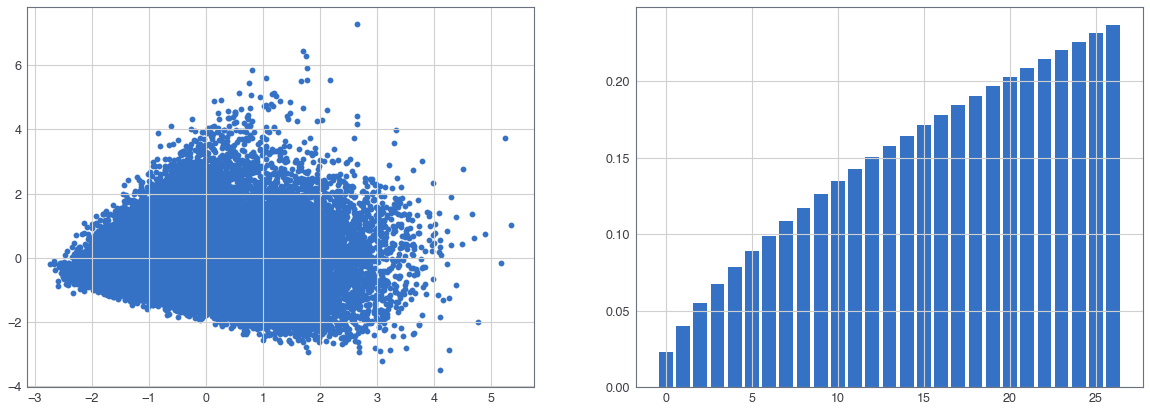

In [35]:
_, ax = plt.subplots(1, 2, figsize = (20, 7))
pca = PCA(n_components = 27)
fit = pca.fit(spikes.iloc[:, 0:-6].values)
expvar = fit.explained_variance_ratio_
form = pca.fit_transform(spikes.iloc[:, 0:-6].values) 
ax[0].scatter(form[:, 0], form[:, 1])
ax[1].bar(np.arange(len(expvar)), np.cumsum(expvar))
plt.show() 

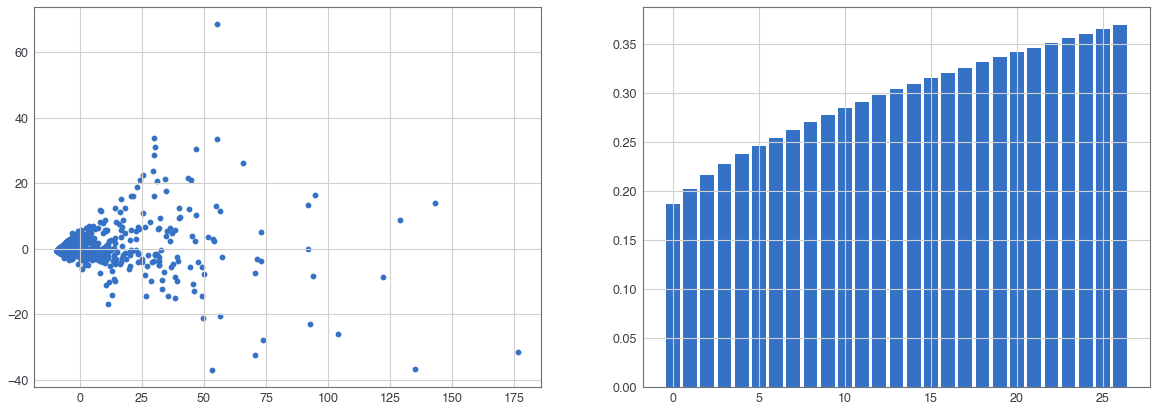

In [212]:
_, ax = plt.subplots(1, 2, figsize = (20, 7))
pca = PCA(n_components = 27)
fit = pca.fit(spikes.iloc[:, 0:-6].values.T)
expvar = fit.explained_variance_ratio_
form = pca.fit_transform(spikes.iloc[:, 0:-6].values.T) 
ax[0].scatter(form[:, 0], form[:, 1])
ax[1].bar(np.arange(len(expvar)), np.cumsum(expvar))
plt.show() 

In [ ]:
tsne = manifold.TSNE()
form = tsne.fit_transform(spikes.iloc[:6000, 0:-6])
plt.plot(form[:, 0], form[:, 1])

####  pulls

In [15]:
#feedback
#np.load('/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/test load/Lederberg_2017-12-05/trials.feedbackType.npy')

#brain area
#pd.read_csv(
   # '/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/test load/Lederberg_2017-12-05/channels.brainLocation.tsv',
    #delim_whitespace = True) 

#clusters -> channel mapper
#clus = np.load('/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/Forssmann_2017-11-04/clusters.peakChannel.npy',
 #             allow_pickle = True)
#np.unique(clus)
#clus.shape
#spks and spk cluster map
#sp = np.load('/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/Forssmann_2017-11-04/spikes.clusters.npy')
#sp2 = np.load('/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/Forssmann_2017-11-04/spikes.times.npy')
#sp.shape == sp2.shape
#stim onset
#arr = np.load('/Users/albertwakhloo/Desktop/theoretical neuroscience/neuromatch/steinmetz full/allData/test load/Lederberg_2017-12-05/trials.visualStim_times.npy',
       #       allow_pickle = True) 
#arr

def load_dat(folders, truncate = None, return_stim = False) : 
    neural_df = pd.DataFrame(columns = ['spike_t', 'area', 'maus', 'stim_t'])
    for mouse, name in enumerate(folders) : 
        spk = np.load(f'{name}/spikes.times.npy', allow_pickle = True)
        spk = spk.reshape((spk.shape[0], ))
        if truncate != None : spk = spk[spk <= truncate]
            
        stim = np.load(f'{name}/trials.visualStim_times.npy', allow_pickle = True)
        neurons = np.load(f'{name}/spikes.clusters.npy', allow_pickle = True)
        neurons = neurons.reshape((neurons.shape[0], )) #array with neuron labels for each spike time
        if truncate != None : neurons = neurons[:spk.shape[0]] #cut to relevant subset

        loc = pd.read_csv(f'{name}/channels.brainLocation.tsv', delim_whitespace = True)
        loc = loc['allen_ontology'].values #location of the ith channel

        channel = np.load(f'{name}/clusters.peakChannel.npy', allow_pickle = True)
        channel = channel.reshape(channel.shape[0], ).astype('int') #channel of the ith cluster
        #IDs mapping cluster - > channel. this is a clusterx1 array with each entry containing the channel ID of the ith cluster 
        print('Mapping neurons to channels ... ')
        cluster_channel = [channel[cluster] for cluster in neurons] #generate an array containing the channel for each neuron
        #yields a list the same size as neurons with entries corresponding to the channel of that cluster
        print('Mapping channels to brain areas ...')
        brain_area = [loc[i] for i in cluster_channel] 
        #pull brain area 
        neural_subj_df = pd.DataFrame({'spike_t' : spk, 'neuron' : neurons, 'maus' : i, 
                                       'area' : brain_area}, index = np.arange(spk.shape[0]))
        neural_subj_df['maus'] = mouse
        neural_df = neural_df.append(neural_subj_df, ignore_index = True)
        
    if return_stim == True : 
        all_subj_df = pd.DataFrame(columns = ['cl', 'cr', 'stimtime', 'reward', 'response_type',
                                                 'rt'])
        print('''Getting behavioral data ...''')
        for i, folder in enumerate(folders) : 
            '''Grab all stimulus vectors. For the time paramaeters, we can use truncate to slice out
            the relevant indices. The shapes of these truncated versions can then be used to reshape
            categorical variables like contrast and reward type.'''
            stim = stim[stim < truncate]
            cl = np.load(f'{folder}/trials.visualStim_contrastLeft.npy', allow_pickle = True)
            cl = cl.reshape(cl.shape[0], )
            cl = cl[:stim.shape[0]]
            cr = np.load(f'{folder}/trials.visualStim_contrastRight.npy', allow_pickle = True)
            cr = cr.reshape(cr.shape[0], )
            cr = cr[:stim.shape[0]]
                
            rew_time = np.load(f'{folder}/trials.feedback_times.npy', allow_pickle = True)
            rew_time = rew_time.reshape(rew_time.shape[0], )
            rew_time = rew_time[rew_time < truncate]
            rew_type = np.load(f'{folder}/trials.feedbackType.npy', allow_pickle = True)
            rew_type = rew_type.reshape(rew_type.shape[0], )
            rew_type = rew_type[:rew_time.shape[0]]
                
            response_t =  np.load(f'{folder}/trials.response_times.npy', allow_pickle = True)
            response_t = response_t.reshape(response_t.shape[0], )
            response_t = response_t[response_t < truncate]
            response_type = np.load(f'{folder}/trials.response_choice.npy', allow_pickle = True)
            response_type = response_type.reshape(response_type.shape[0], )
            response_type = response_type[:response_t.shape[0]]
            
            
            
            subj_df = pd.DataFrame({'cl' : cl, 'cr' : cr, 'stimtime' : stim, 'reward' : rew_type,
                            'response_type' : response_type, 'rt' : response_t})
            subj_df['maus'] = i
            all_subj_df = all_subj_df.append(subj_df, ignore_index = True)
        print('''~~~ Time is literally god ~~~''')
        return neural_df, all_subj_df
            
    else: return neural_df